### Giving Life to Equations

#### Advanced Example: Implementing Backpropagation Manually with TensorFlow

##### Model Architecture and Components

Before writing the code, let's detail the architecture of the Perceptron we will build to solve the MNIST problem. The model we are about to implement is a direct reflection of the multi-layer theory and the learning process we have explored.

The model is a multi-layer Perceptron, following the general structure of nested function composition, as described in equation <<eq-hat_y-geral-0>>. The input vector, `x`, with the 784 pixels of each image, flows through the three layers of the network. Each layer implements the fundamental linearity operation `y = Wx + b`, as we saw in its most basic form in <<eq-output-0>>, followed by a non-linear activation function to add representational power to the model.

Specifically, our architecture is as follows:

* **Hidden Layers:** The first hidden layer has 128 neurons, and the second has 64. For these layers, we use the **ReLU** (Rectified Linear Unit) activation function, a modern and efficient choice for avoiding the vanishing gradient problem.
* **Output Layer:** The final layer is composed of 10 neurons, one for each digit class (0 to 9). In this layer, we will apply the **Sigmoid** function, which maps the output of each neuron to a value between 0 and 1. Both functions, ReLU and Sigmoid, are detailed in the Activation Functions table <<activations>>.
* **Cost Function:** To measure the error `E` between the network's prediction `P` and the desired response `z`, we will use the **Mean Squared Error (MSE)** cost function. As we are training in batches, the final error we optimize at each step is the average of the individual errors for each example in the batch, a concept formalized in <<eq-error-geral-3>>. The base formula for MSE can be found in the Cost Functions table <<cost-functions>>.

With this structure defined, the following code will translate each of these components into a functional TensorFlow class.

This notebook is, in a way, a continuation of our previous example. Now, we will see how high-level frameworks facilitate and accelerate training with their parallel processing technology.

To take advantage of this technology that allows for optimized batch training and still exemplify the use of the equations we learned, we will "open the black box" of the `tape.gradient()` function and implement the backpropagation algorithm that was mathematically derived in the book ourselves.

The objective is to demonstrate that the equations for `∂E/∂W` and `∂E/∂b` are not just theory. They are the algorithm.

To do this, we will:

1.  Modify our model so that it gives us the activations and linearities of each layer.
2.  Create a training loop that manually calculates the gradients for each layer, from back to front, using formulas <<eq-dE_dW-geral-0>> and <<eq-de_dbaryl_geral-0-1>>.
3.  Use the TensorFlow optimizer only to *apply* the gradients that we have calculated ourselves.

This is the deep and explicit connection between the mathematics of learning and its computational implementation.


In [1]:
# Step 1: Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Step 2: Load the MNIST dataset
(x_train, z_train), (x_test, z_test) = tf.keras.datasets.mnist.load_data()

# Step 3: Pre-process the Data
# 3.1 - Normalization and Flattening
x_train = (x_train.astype("float32") / 255.0).reshape(60000, 784)
x_test = (x_test.astype("float32") / 255.0).reshape(10000, 784)

# 3.2 - One-Hot Encoding of the Desired Responses (z)
z_train = tf.keras.utils.to_categorical(z_train, num_classes=10)
z_test = tf.keras.utils.to_categorical(z_test, num_classes=10)

# THEN, we ensure the array's type is float32 using .astype()
z_train = z_train.astype('float32')
z_test = z_test.astype('float32')

print("Data ready for training!")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Data ready for training!


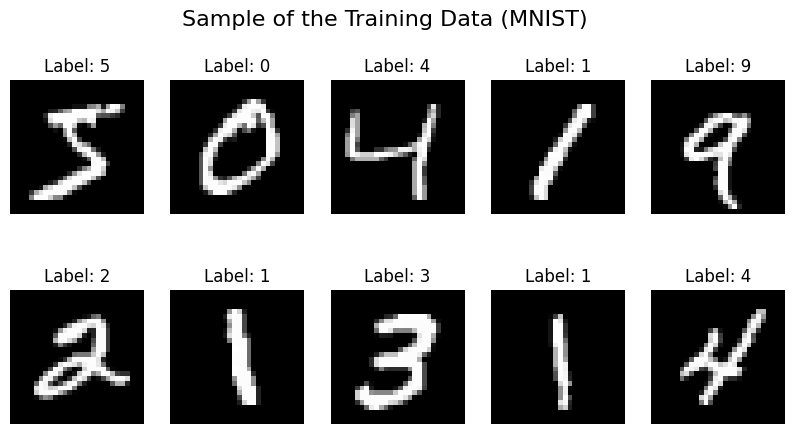

In [2]:
# Let's visualize some images to understand what we are working with.
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {np.argmax(z_train[i])}")
    plt.axis('off')
plt.suptitle("Sample of the Training Data (MNIST)", fontsize=16)
plt.show()

In [3]:
# The Perceptron class has been modified to return intermediate values
# (linearities 'y' and activations 'a'), which are crucial for backpropagation.

class Perceptron(tf.keras.Model):
    def __init__(self, layer_sizes):
        super(Perceptron, self).__init__()
        self.num_camadas = len(layer_sizes)
        self.camadas = []
        for units in layer_sizes:
            self.camadas.append(tf.keras.layers.Dense(units, activation=None))

    def call(self, x, return_internals=False):
        """
        Modified forward pass. If return_internals=True, it returns
        the final output and lists with the linearities (y) and activations (a) of each layer.
        """
        a = x

        # ADDED COMMENT:
        # We start the list of activations with the input `x` itself.
        # We consider `x` as the 'activation of layer 0' (a^0).
        # This simplifies access to the 'previous activation' (a^{l-1}) in the backpropagation loop.
        activations = [a]
        linearities = []

        # Hidden layers with ReLU
        for camada in self.camadas[:-1]:
            y = camada(a)
            a = tf.nn.relu(y)
            linearities.append(y)
            activations.append(a)

        # Last layer (output)
        y_final = self.camadas[-1](a)
        P = tf.nn.sigmoid(y_final)
        linearities.append(y_final)
        activations.append(P)

        if return_internals:
            return P, linearities, activations

        return P

In [4]:
# --- Hyperparameters and Instances ---
learning_rate = 0.001
epochs = 10
batch_size = 64

model = Perceptron(layer_sizes=[128, 64, 10])
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Stochastic Gradient Descent
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
cost_function = tf.keras.losses.MeanSquaredError()

# --- Preparing the data batches ---
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, z_train))
train_dataset = train_dataset.shuffle(buffer_size=60000).batch(batch_size)

# --- Training Loop ---
cost_history = []

print("Starting the training with our formulas, explicitly coded...")
for epoch in range(epochs):
    epoch_average_cost = tf.keras.metrics.Mean()

    for x_batch, z_batch in train_dataset:

        P_batch, linearities, activations = model(x_batch, return_internals=True)
        E = cost_function(z_batch, P_batch)

        # ==========================================================
        # 3. BACKPROPAGATION MANUALLY CODED TO EXPLICITLY
        # MIRROR THE EQUATIONS WE DERIVED.
        # ==========================================================

        dE_daL = P_batch - z_batch
        aL = activations[-1]
        daL_dyL = aL * (1 - aL)
        dE_dy = dE_daL * daL_dyL

        final_gradients = []

        for l in reversed(range(model.num_camadas)):
            layer = model.camadas[l]

            # ADDED COMMENT:
            # The activation of the previous layer (a^{l-1}) is necessary for the gradient calculation.
            # Due to how we built the `activations` list, where activations[0] = a^0 (the input 'x'),
            # for layer 'l' of the model (which is 0-indexed), the activation before it
            # is conveniently stored in activations[l].
            a_previous = activations[l]

            # ADDED COMMENT:
            # This is the most crucial step, where theory connects with efficient implementation.
            # The book's equation for dE/dW^l (for one example) is an outer product.
            # For a BATCH, we need the SUM of the outer products for each example.
            # Matrix multiplication (a_previous^T @ dE_dy) is the
            # mathematically equivalent and computationally optimized way to do this.
            # Shape Analysis: [inputs, batch] @ [batch, outputs] -> [inputs, outputs], which is the shape of W^l.
            dE_dW = tf.matmul(a_previous, dE_dy, transpose_a=True)

            dE_db = tf.reduce_sum(dE_dy, axis=0)

            final_gradients.insert(0, dE_db)
            final_gradients.insert(0, dE_dW)

            if l > 0:
                dE_da_previous = tf.matmul(dE_dy, layer.kernel, transpose_b=True)
                relu_derivative = tf.cast(linearities[l-1] > 0, dtype=tf.float32)
                dE_dy = dE_da_previous * relu_derivative

        optimizer.apply_gradients(zip(final_gradients, model.trainable_variables))
        epoch_average_cost.update_state(E)

    cost_history.append(epoch_average_cost.result())
    print(f"Epoch {epoch + 1}/{epochs} - Average Cost: {epoch_average_cost.result():.4f}")

print("Training finished!")

Starting the training with our formulas, explicitly coded...
Epoch 1/10 - Average Cost: 0.0458
Epoch 2/10 - Average Cost: 0.0200
Epoch 3/10 - Average Cost: 0.0158
Epoch 4/10 - Average Cost: 0.0137
Epoch 5/10 - Average Cost: 0.0123
Epoch 6/10 - Average Cost: 0.0112
Epoch 7/10 - Average Cost: 0.0103
Epoch 8/10 - Average Cost: 0.0096
Epoch 9/10 - Average Cost: 0.0090
Epoch 10/10 - Average Cost: 0.0085
Training finished!


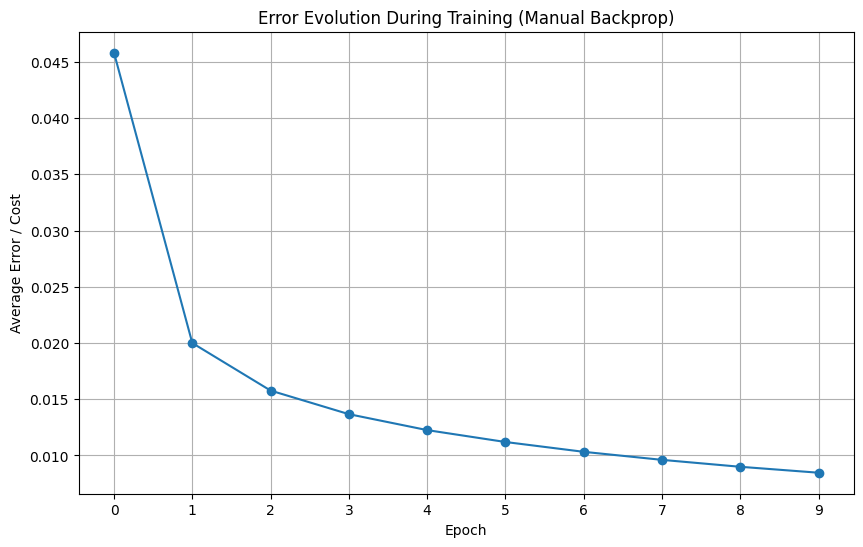

In [5]:
# Plot the cost function graph
plt.figure(figsize=(10, 6))
plt.plot(cost_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average Error / Cost")
plt.title("Error Evolution During Training (Manual Backprop)")
plt.grid(True)
plt.xticks(range(epochs))
plt.show()

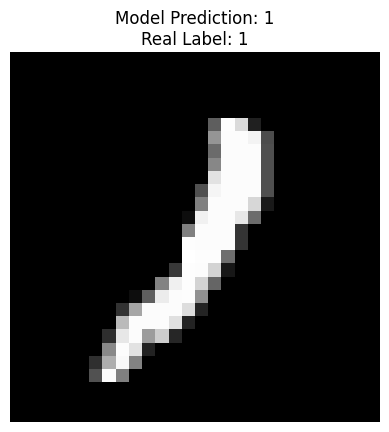

In [8]:
def test_model():
    random_idx = np.random.randint(0, len(x_test))
    img = x_test[random_idx]
    real_label = np.argmax(z_test[random_idx])

    img_for_prediction = np.expand_dims(img, axis=0)

    prediction_vector = model(img_for_prediction)
    predicted_label = np.argmax(prediction_vector)

    plt.imshow(img.reshape(28, 28), cmap='gray')
    plt.title(f"Model Prediction: {predicted_label}\nReal Label: {real_label}")
    plt.axis('off')
    plt.show()

# Execute this cell several times to test!
test_model()